In [1]:
import getfem as gf
import numpy as np
import pyvista as pv

pv.start_xvfb()

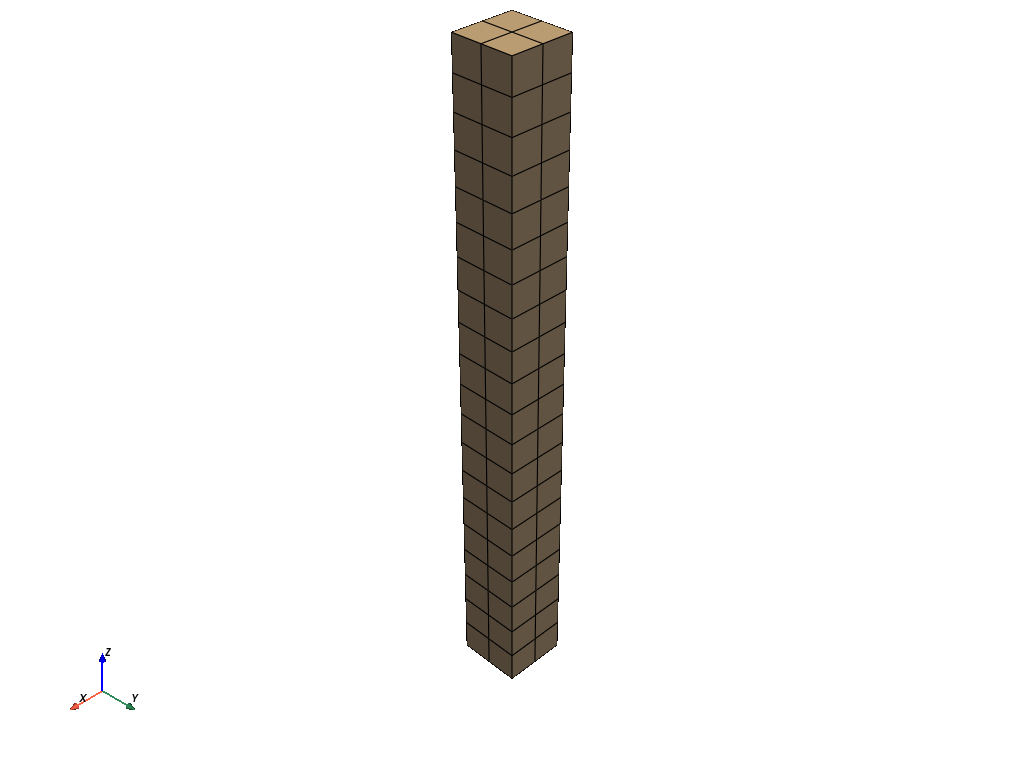

In [2]:
X = np.linspace(0.0, 1000.0, 2 + 1)
Y = np.linspace(0.0, 1000.0, 2 + 1)
Z = np.linspace(0.0, 10000.0, 20 + 1)
mesh = gf.Mesh("cartesian", X, Y, Z)
mesh.export_to_vtk("mesh.vtk", "ascii")
m = pv.read("mesh.vtk")
m.plot(show_edges="True", jupyter_backend="static")

In [3]:
elements_degree = 2
mfu = gf.MeshFem(mesh, 3)
mfu.set_classical_fem(elements_degree)
mfd = gf.MeshFem(mesh, 1)
mfd.set_classical_fem(elements_degree)

In [4]:
mim = gf.MeshIm(mesh, elements_degree*2)
print(mim)


BEGIN MESH_IM

 CONVEX 0 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 1 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 2 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 3 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 4 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 5 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 6 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 7 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 8 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 9 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 10 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 11 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4),IM_GAUSS1D(4)),IM_GAUSS1D(4))'
 CONVEX 12 'IM_PRODUCT(IM_PRODUCT(IM_GAUSS1D(4

In [5]:
rho = 7.874e-06 # kg/mm3
M = gf.asm_mass_matrix(mim, mfu)
M.scale(rho)

In [6]:
E = 205000.0  # N/mm2
Nu = 0.0
Lambda = E * Nu / ((1 + Nu) * (1 - 2 * Nu))
Mu = E / (2 * (1 + Nu))
Lambdas = np.repeat([Lambda], mfd.nbdof())
Mus = np.repeat(Mu, mfd.nbdof())
K = gf.asm_linear_elasticity(mim, mfu, mfd, Lambdas, Mus)

In [7]:
A = np.linalg.inv(M.full()) @ K.full()
omega2, vecs = np.linalg.eig(A)

In [8]:
omega2_sort = np.sort(omega2)
sort_index = np.argsort(omega2)

In [9]:
print(omega2_sort[:10])

[-2.28576326e-08+0.j -1.94692563e-08+0.j -1.12079223e-08+0.j
 -4.66263072e-09+0.j  0.00000000e+00+0.j  4.37559938e-09+0.j
  1.02011998e+02+0.j  1.02011998e+02+0.j  7.01499874e+02+0.j
  7.01499874e+02+0.j]


In [10]:
f1 = np.sqrt(omega2_sort[6]) / (2.0 * np.pi)
print(f1.real, "Hz")

1.6074806705093223 Hz


In [11]:
U = vecs[:, sort_index[6]].real
mfu.export_to_vtk("mfu.vtk", "ascii", mfu, U, "U")

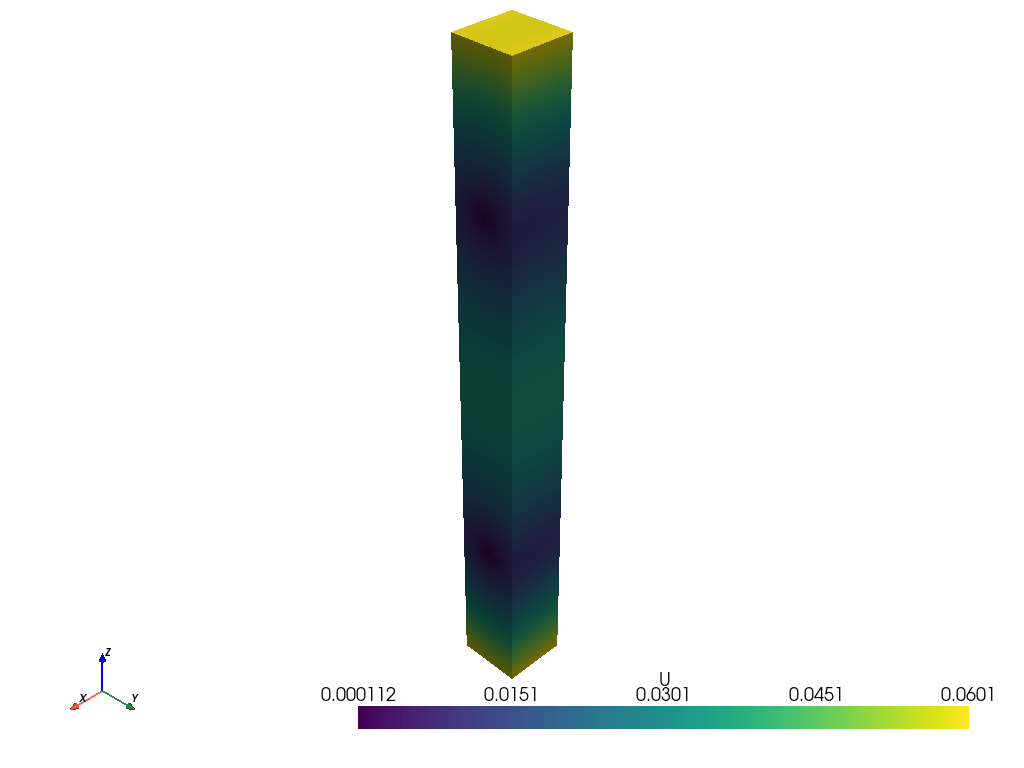

In [12]:
m = pv.read("mfu.vtk")
m.plot(scalars="U", jupyter_backend="static")

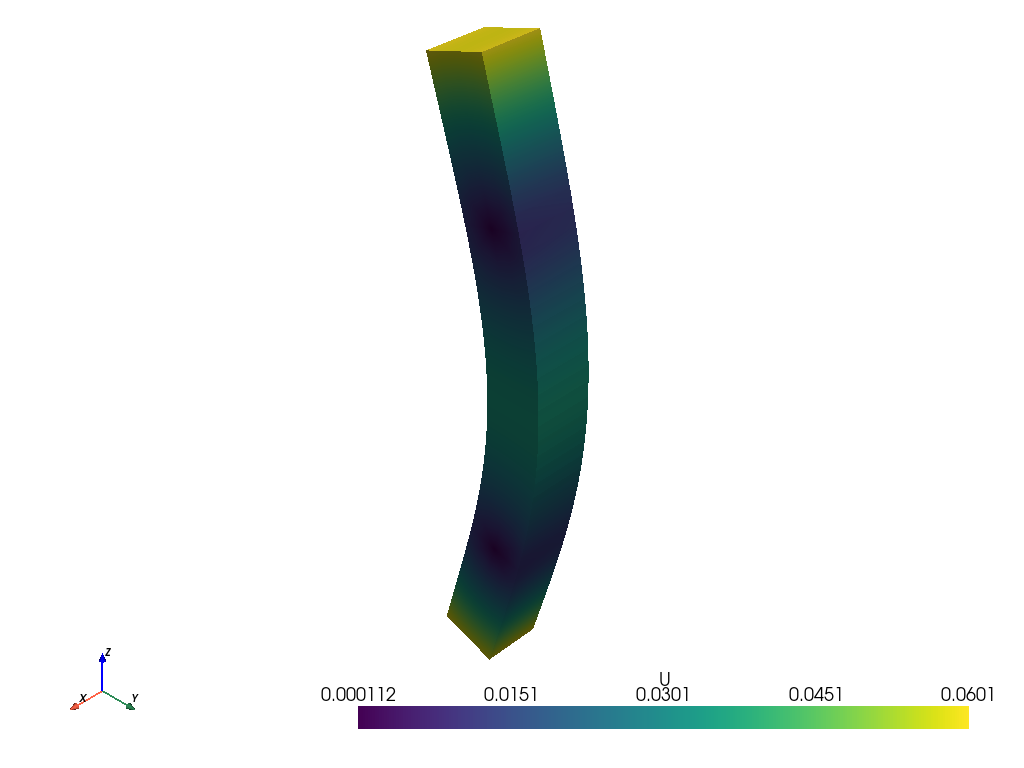

In [13]:
w = m.warp_by_vector("U", factor=10000.0)
w.plot(scalars="U", jupyter_backend="static")

In [14]:
L = 10000.0
clambda = 4.730
b = 1000.0
h = 1000.0
A = b * h
I = b * h ** 3 / 12.0
f = 1.0 / (2.0 * np.pi) * clambda ** 2 / L ** 2 * np.sqrt((E * I) / (rho * A))
print("f = ", f, "Hz")

f =  1.6585593440339137 Hz


In [15]:
from scipy import io
from scipy.sparse.linalg import eigsh
import matplotlib.pyplot as plt

In [16]:
K.save("mm", "K.mtx")
M.save("mm", "M.mtx")

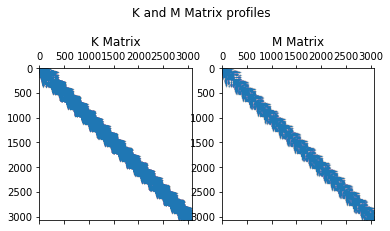

In [17]:
pk = io.mmread("K.mtx")
pm = io.mmread("M.mtx")

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("K and M Matrix profiles")
ax1.spy(pk, markersize=0.01)
ax1.set_title("K Matrix")
ax2.spy(pm, markersize=0.01)
ax2.set_title("M Matrix")
plt.show(block=True)

In [18]:
omega2, vecs = eigsh(A=pk, M=pm, k=10, sigma=-0.0001, which="LA")

In [19]:
print(omega2)

[-9.23424929e-11 -3.59889245e-11 -1.63622615e-11  4.09915897e-11
  1.06382852e-10  1.57732646e-10  1.02011998e+02  1.02011999e+02
  7.01499874e+02  7.01499965e+02]


In [20]:
f1 = np.sqrt(omega2[6]) / (2.0 * np.pi)
print(f1.real, "Hz")

1.6074806705200215 Hz
